# KNN REGRESSOR

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# data viewer
from sscode.config import data_path
from sscode.data import Loader, load_moana_hindcast_ss, load_geocean_tgs
from sscode.pca import PCA_DynamicPred
from sscode.knn import KNN_Regression
from sscode.plotting.data import plot_uhslc_locations

# warnings
import warnings
warnings.filterwarnings('ignore')

## Load the data

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



## Load / calculate the pcs

In [3]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    # from sscode.plotting.pca import plot_pcs
    # plot_pcs(pcs_cfsr,n_plot=3)
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=True,pca_plot=(True,False)
    )

## KNN regression with regional predictor

This is a snippet of the model outlook:

```python

    # perform the knn regression
    neigh = KNeighborsRegressor() # TODO: add params
    # specify parameters to test
    param_grid = {
        'n_neighbors': np.arange(1,k_neighbors,5),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    # use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(
        neigh, param_grid, cv=cv_folds,
        scoring='explained_variance',
        verbose=1
    ) 
    # TODO: add verbose and cv, DONE!!

    # fit model to data
    knn_gscv.fit(X, y) # input total data
    prediction = knn_gscv.predict(X)
    
    
```

where the best number of neighbors is selected, cross-validating the training and testing sizes!!

In [4]:
run = False
if run:
    # perform the KNN-regression (regional)
    stats_regional = []
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),8
    )
    for stat in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat, model, train_times = KNN_Regression(
            pcs_cfsr, ss_moana
        ) # pre-loaded pcs
        stats_regional.append(stats_stat)
    # save the statistics
    stats_regional = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_regional)[:,0]),
            'si':(('station'),np.array(stats_regional)[:,1]),
            'rmse':(('station'),np.array(stats_regional)[:,2]),
            'pearson':(('station'),np.array(stats_regional)[:,3]),
            'spearman':(('station'),np.array(stats_regional)[:,4]),
            'rscore':(('station'),np.array(stats_regional)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon)
        },
        coords={
            'station': sites_regional
        }
    )
    # local copy
    if True:
        stats_regional.to_netcdf(data_path+'/statistics/stats_knn_regional_daily.nc')
else:
    stats_regional = xr.open_dataset(
        data_path+'/statistics/stats_knn_regional_daily.nc'
    )

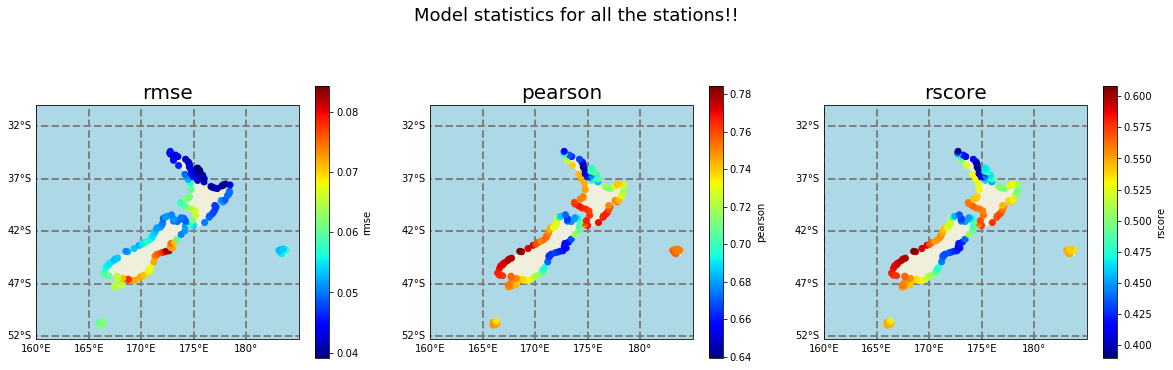

In [5]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_regional,plot_stats=['rmse','pearson','rscore'])

## KNN regression in the UHSLC tidal gauges + validation

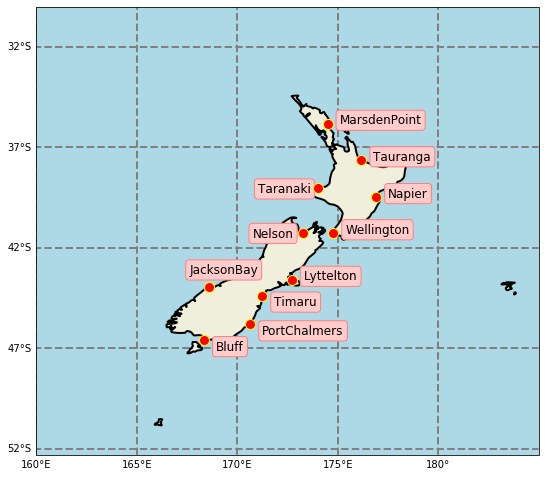

In [6]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



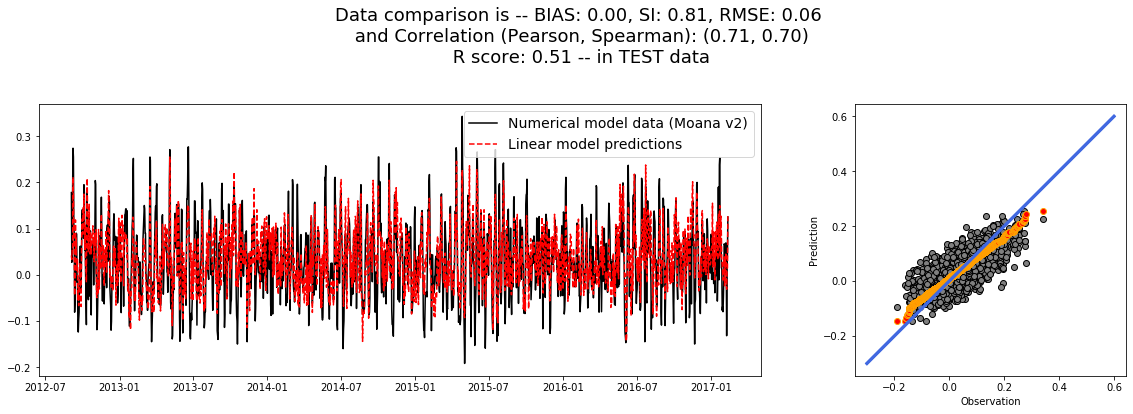

Data comparison is -- BIAS: 0.00, SI: 0.81, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.71, 0.70)
 R score: 0.51 -- in TEST data


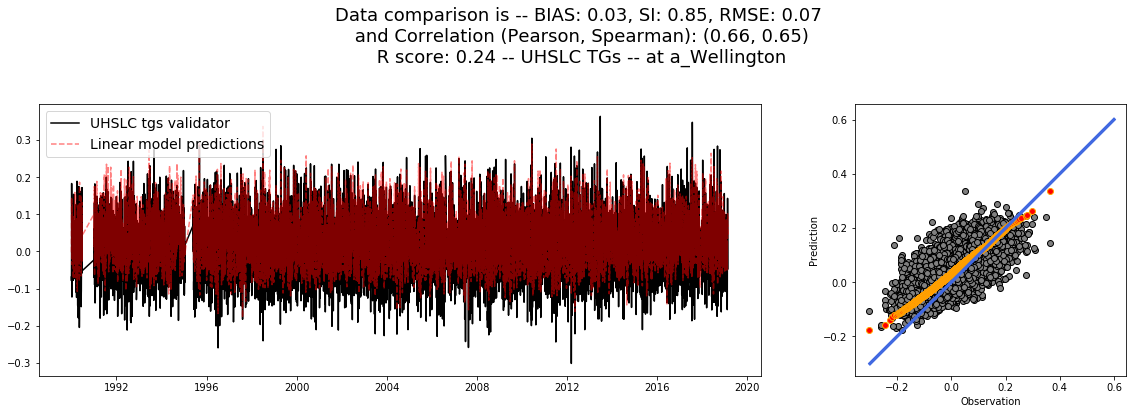


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



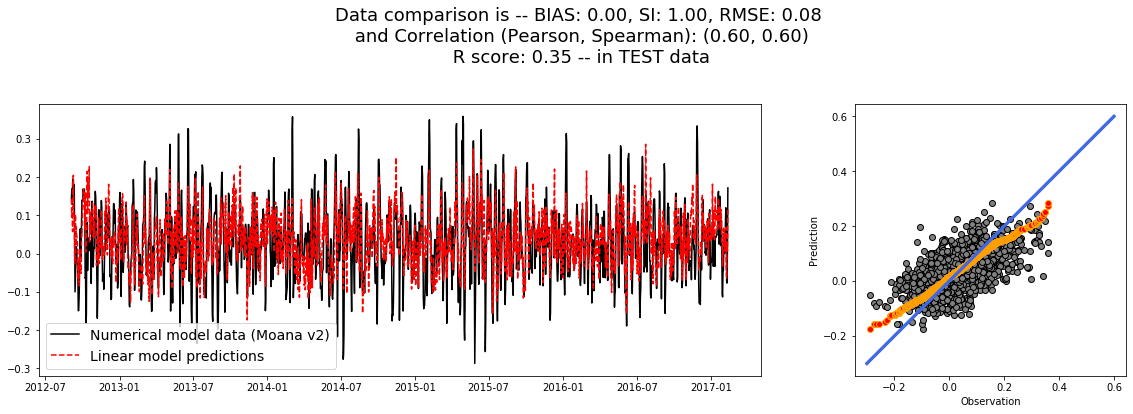

Data comparison is -- BIAS: 0.00, SI: 1.00, RMSE: 0.08
 and Correlation (Pearson, Spearman): (0.60, 0.60)
 R score: 0.35 -- in TEST data


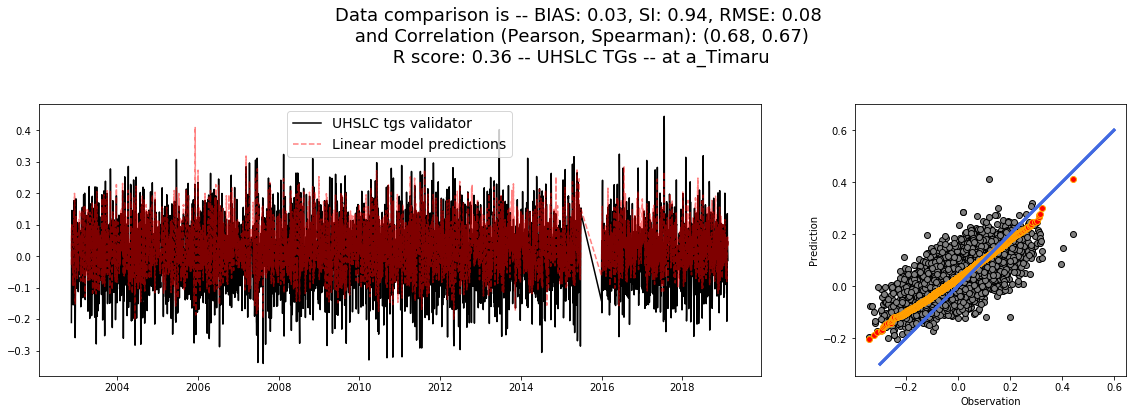


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



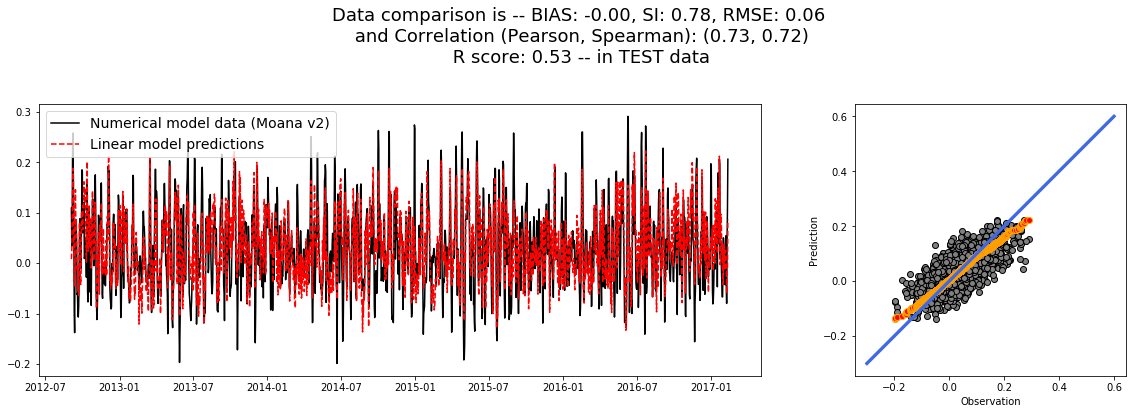

Data comparison is -- BIAS: -0.00, SI: 0.78, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.73, 0.72)
 R score: 0.53 -- in TEST data


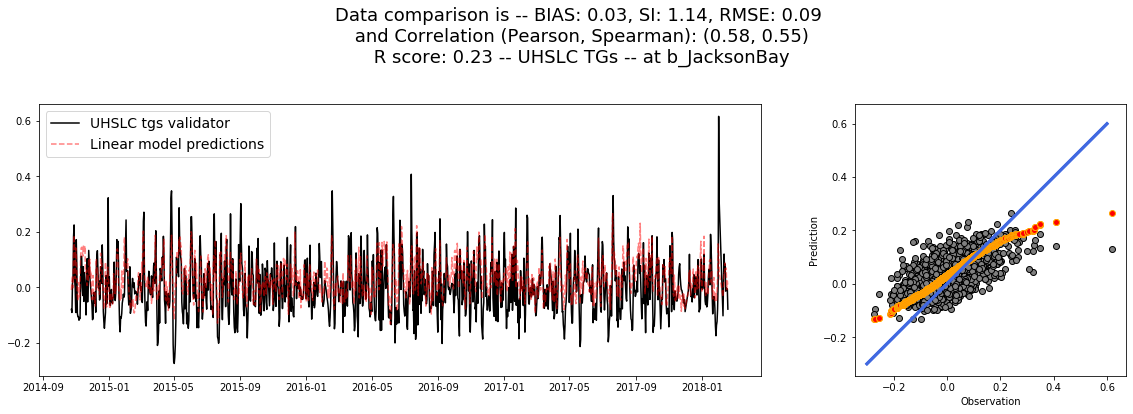


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



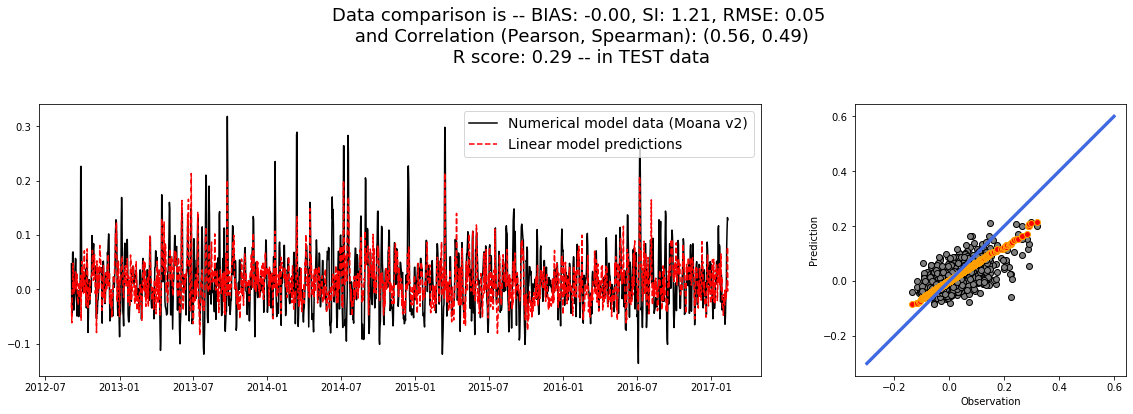

Data comparison is -- BIAS: -0.00, SI: 1.21, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.56, 0.49)
 R score: 0.29 -- in TEST data


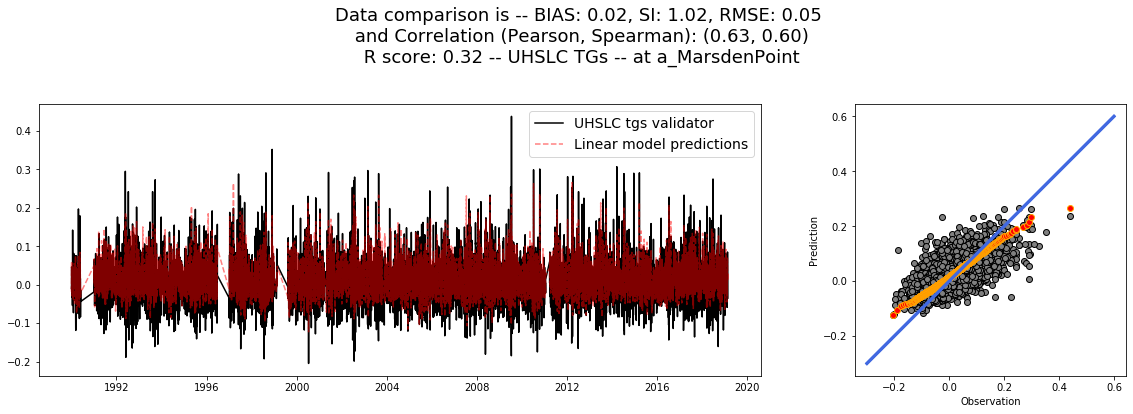


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



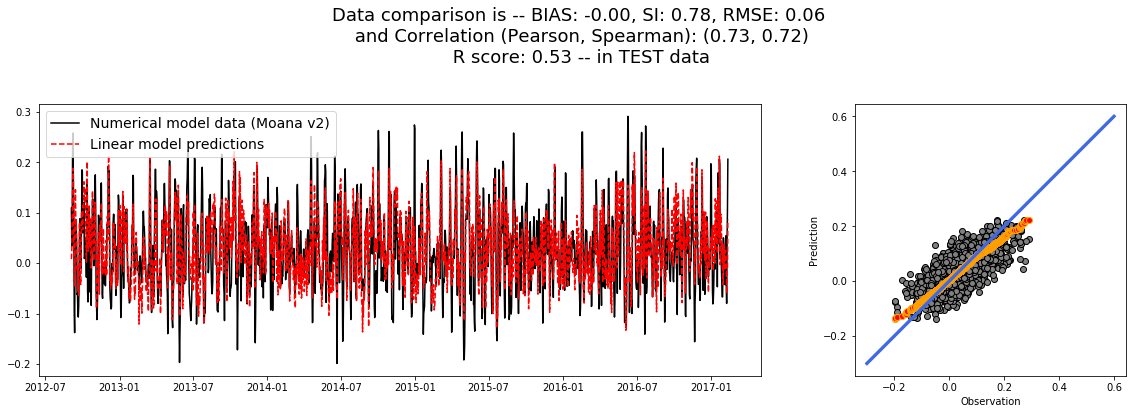

Data comparison is -- BIAS: -0.00, SI: 0.78, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.73, 0.72)
 R score: 0.53 -- in TEST data


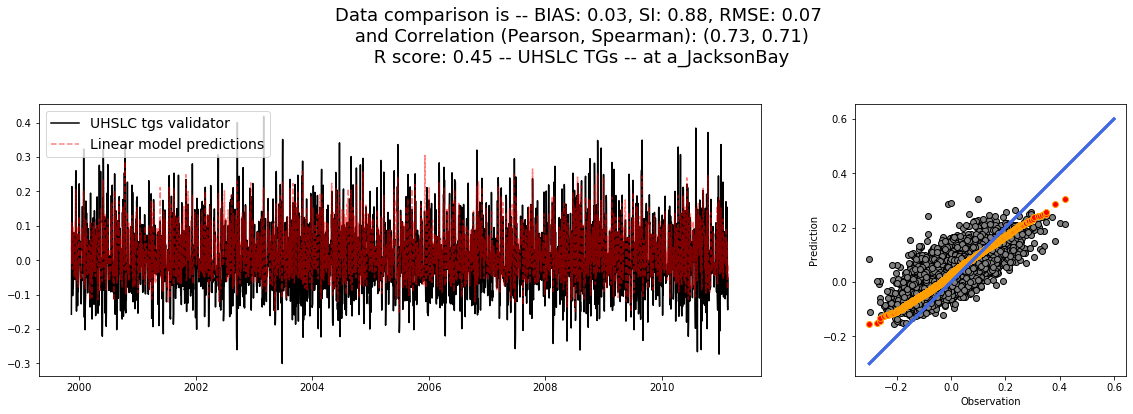


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



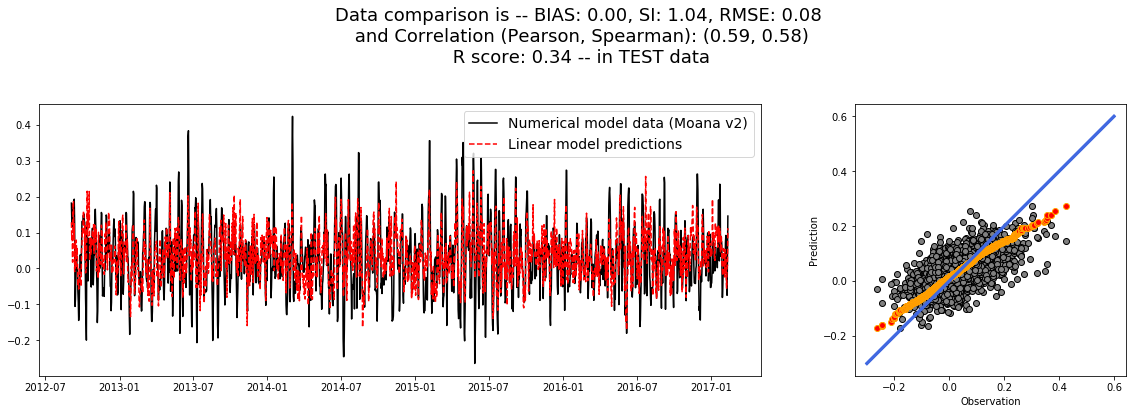

Data comparison is -- BIAS: 0.00, SI: 1.04, RMSE: 0.08
 and Correlation (Pearson, Spearman): (0.59, 0.58)
 R score: 0.34 -- in TEST data


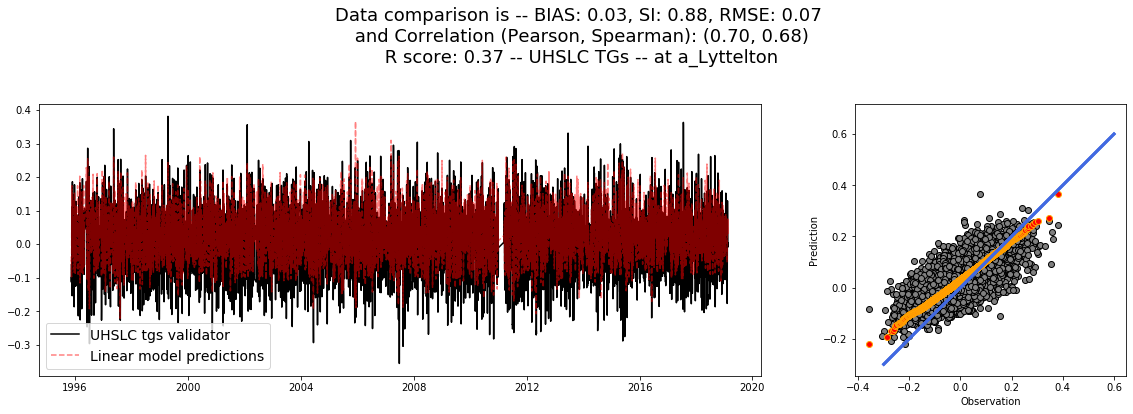


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



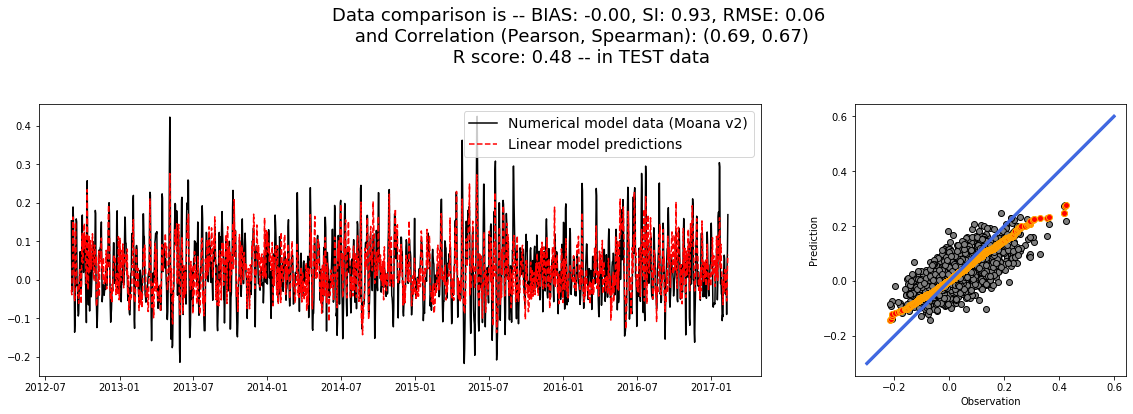

Data comparison is -- BIAS: -0.00, SI: 0.93, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.69, 0.67)
 R score: 0.48 -- in TEST data


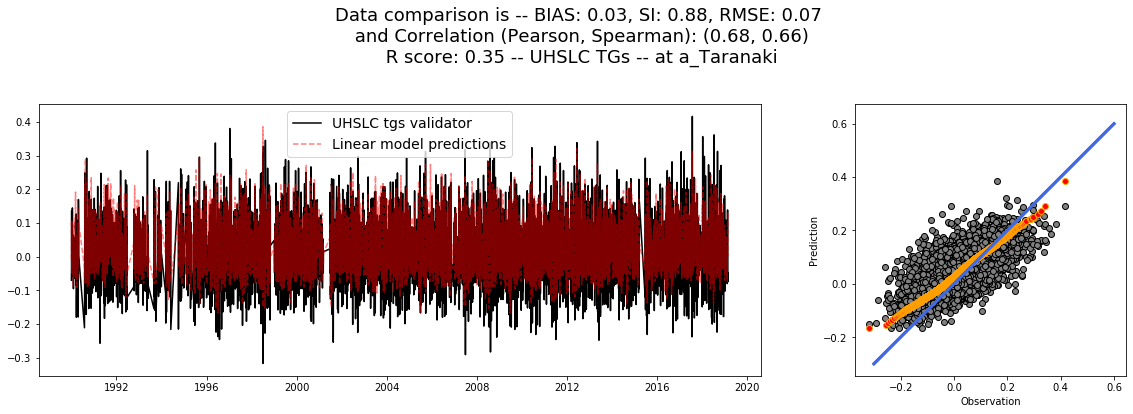


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



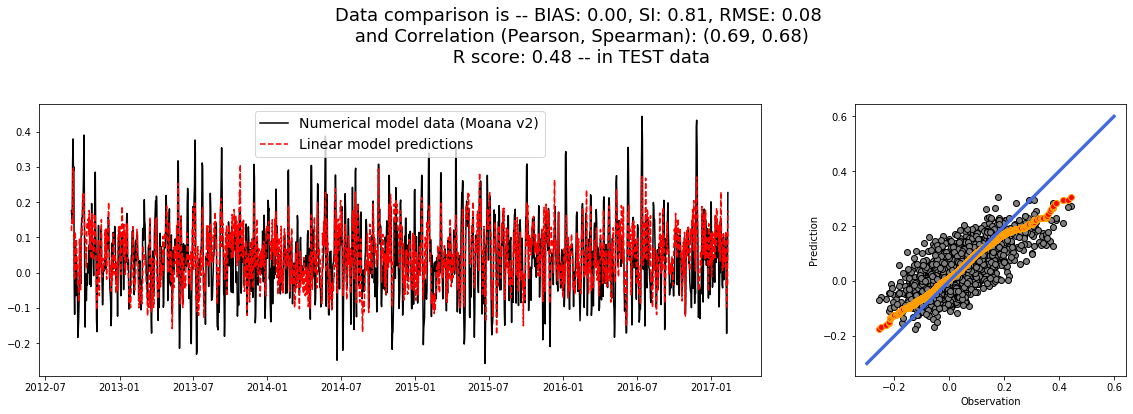

Data comparison is -- BIAS: 0.00, SI: 0.81, RMSE: 0.08
 and Correlation (Pearson, Spearman): (0.69, 0.68)
 R score: 0.48 -- in TEST data


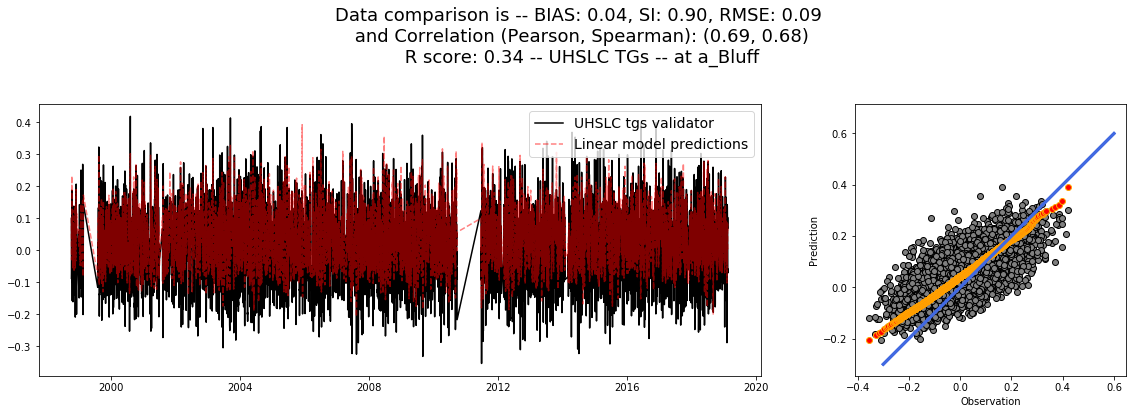


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



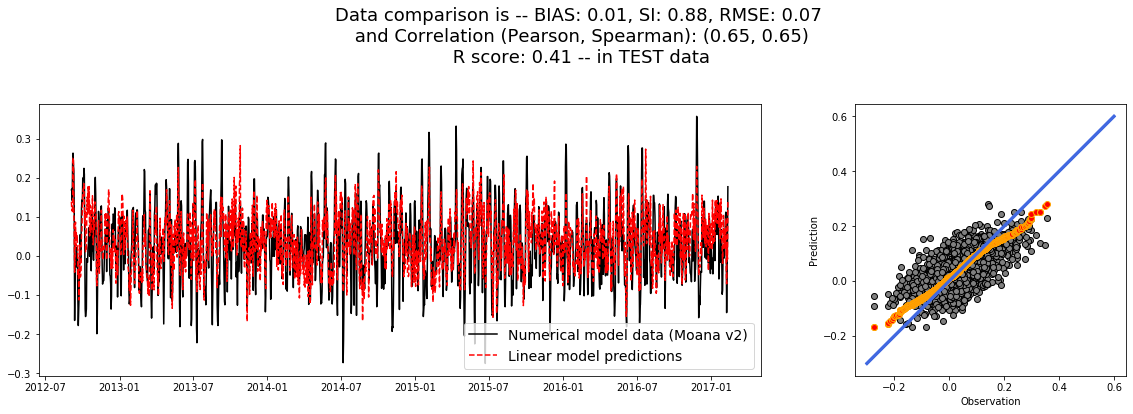

Data comparison is -- BIAS: 0.01, SI: 0.88, RMSE: 0.07
 and Correlation (Pearson, Spearman): (0.65, 0.65)
 R score: 0.41 -- in TEST data


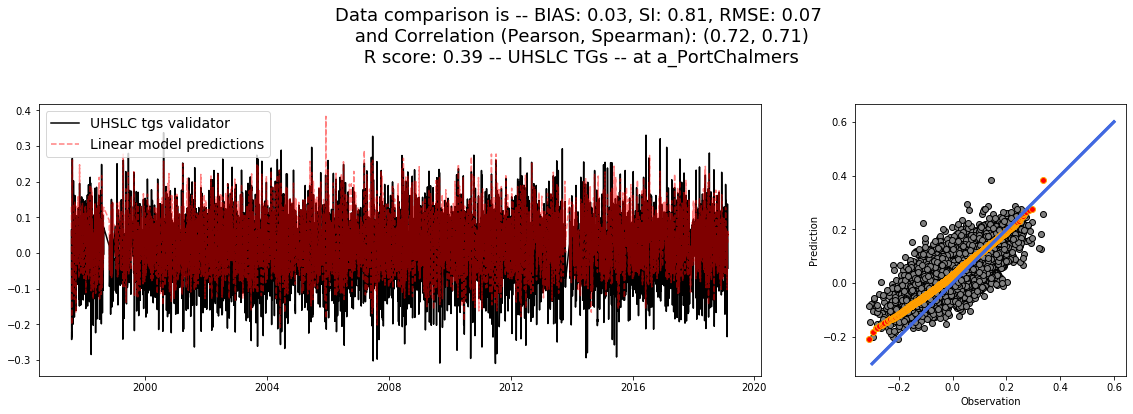


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



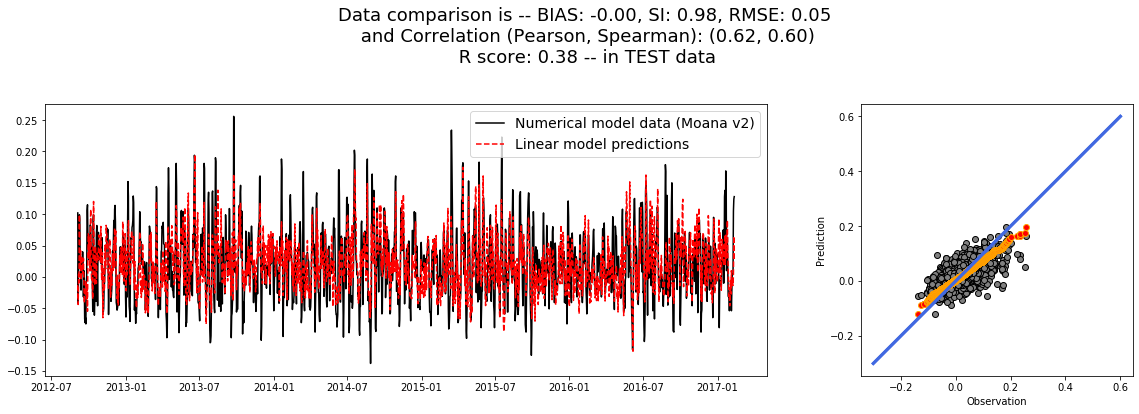

Data comparison is -- BIAS: -0.00, SI: 0.98, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.62, 0.60)
 R score: 0.38 -- in TEST data


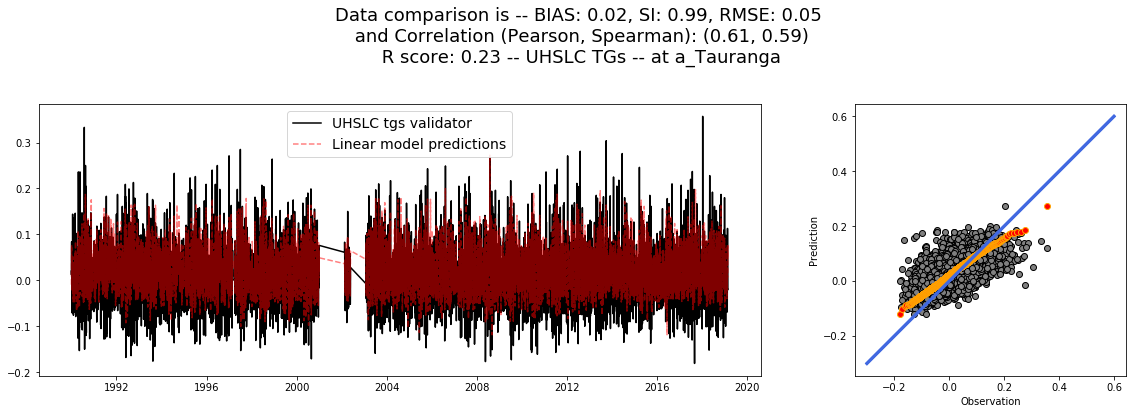


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



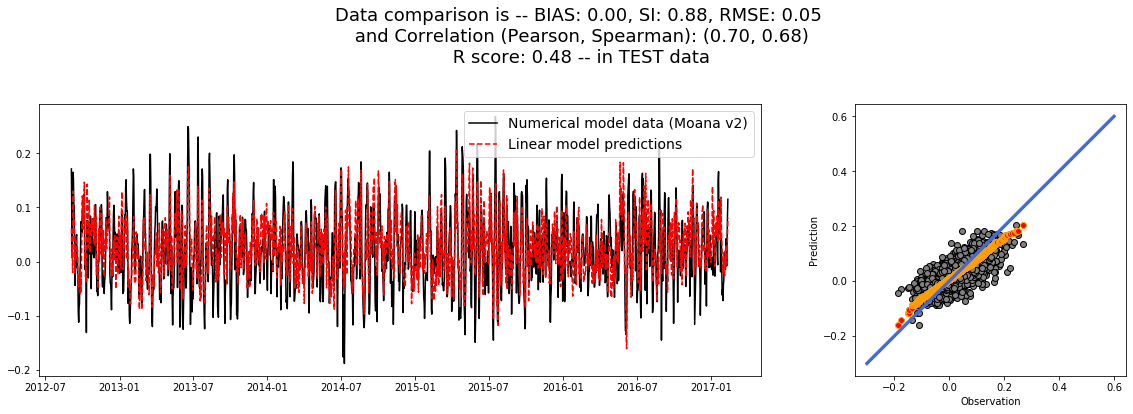

Data comparison is -- BIAS: 0.00, SI: 0.88, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.70, 0.68)
 R score: 0.48 -- in TEST data


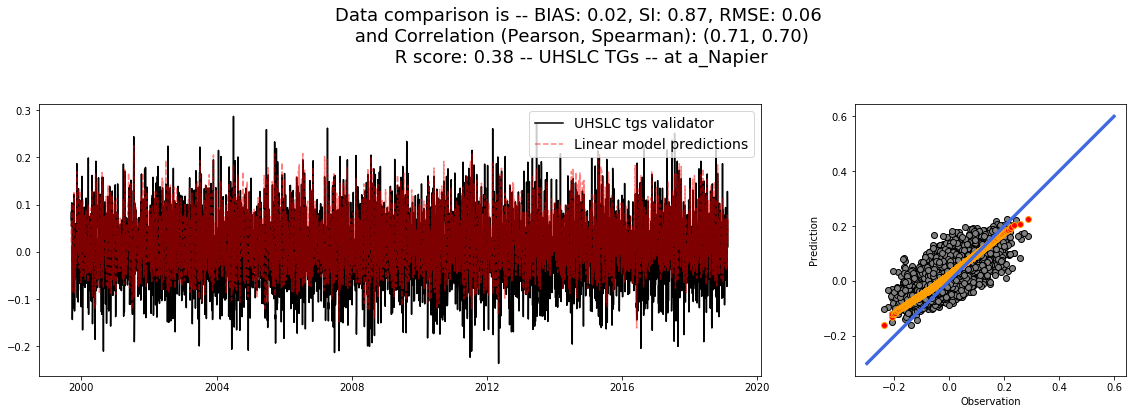


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



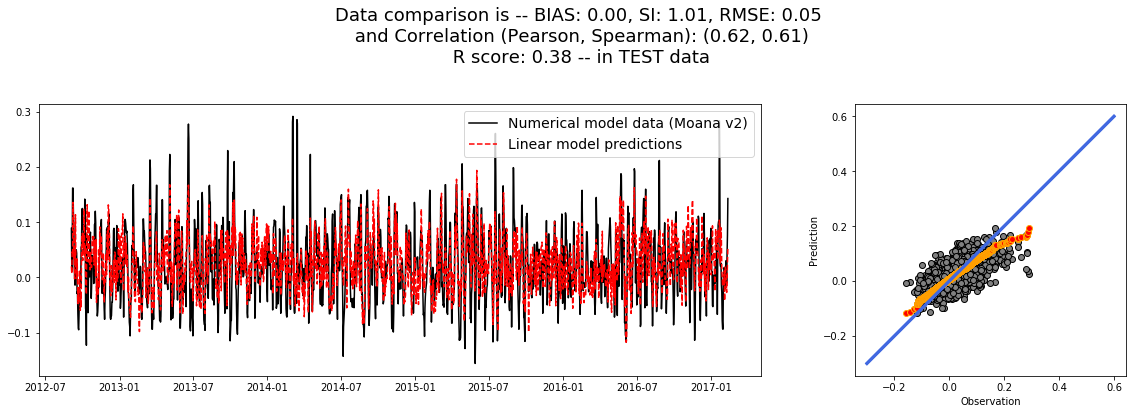

Data comparison is -- BIAS: 0.00, SI: 1.01, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.62, 0.61)
 R score: 0.38 -- in TEST data


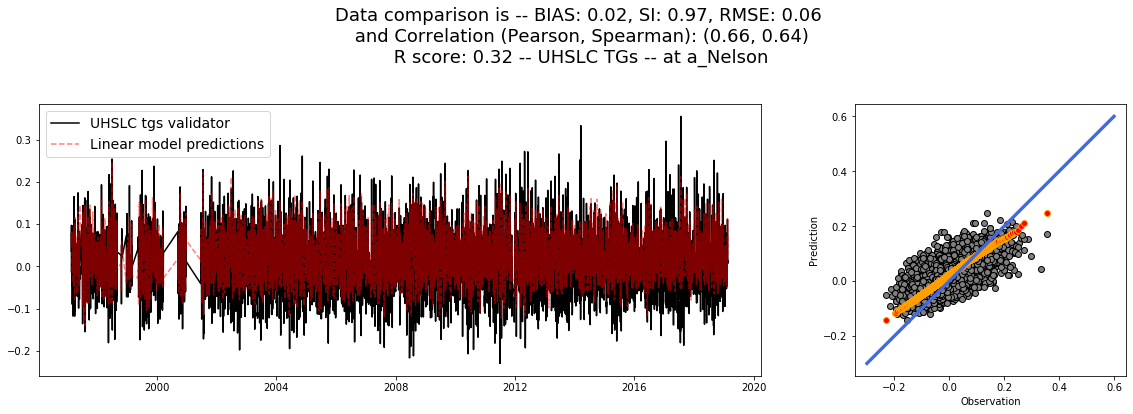

In [7]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
for istat,stat in enumerate(clos_to_uhslc):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    stats_stat, model, train_times = KNN_Regression(
        pcs_cfsr, ss_moana, 
        validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        ), 
        plot_results=True, verbose=True, k_neighbors=4, train_size=0.8
    )
    stats.append(stats_stat)

## Check KNN reconstructions

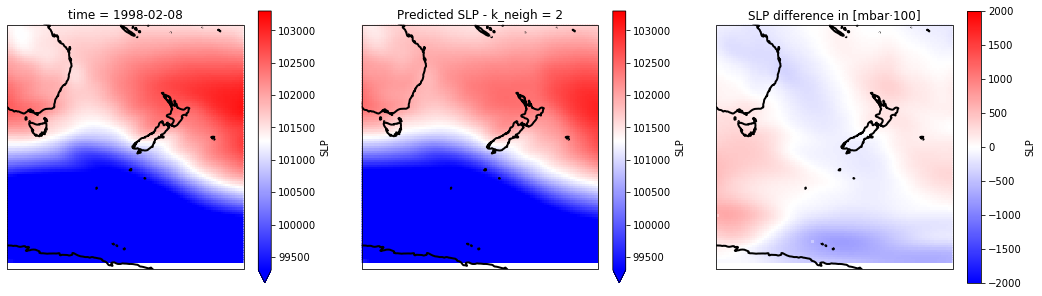

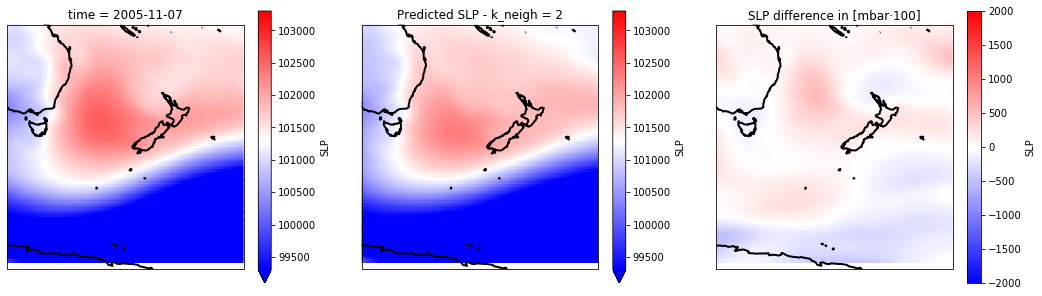

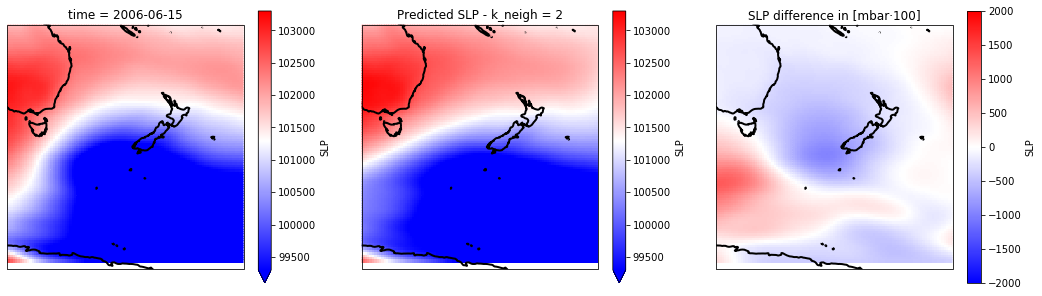

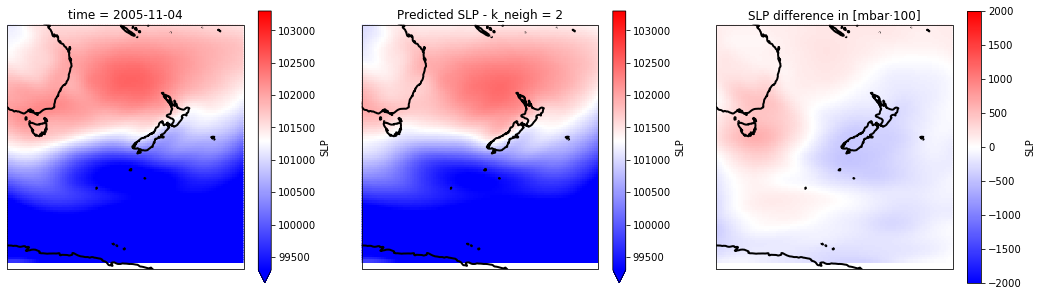

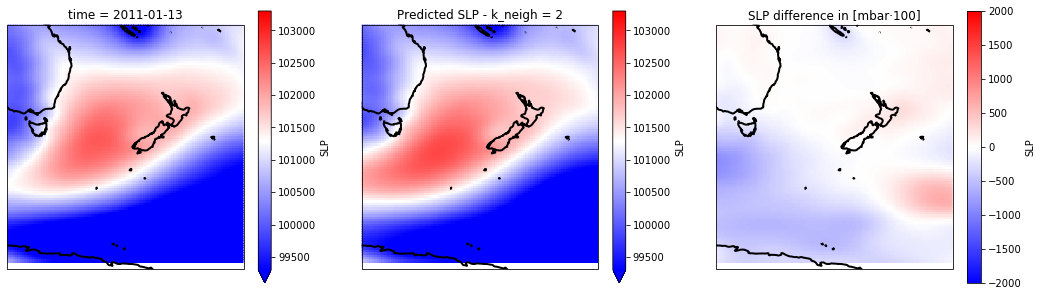

In [10]:
# import custom plotting variables
from sscode.config import default_location, default_region
from sscode.plotting.config import _figsize
from sscode.plotting.utils import plot_ccrs_nz

# find similarities between real and kneighbors
n_times = 5 # number of validations/plots
k_neighbors = 2 # number of neighbors to search
# plotting fig and axes
for time in train_times[np.random.randint(0,len(train_times),n_times)]:
    fig, axes = plt.subplots(
        ncols=3,figsize=_figsize,
        subplot_kw={
            'projection':ccrs.PlateCarree(
                central_longitude=default_location[0]
            )
        }
    )
    real = load_cfsr_moana_uhslc.predictor_slp.sel(time=time)
    real.plot(
        cmap='bwr',vmin=101300-2000,vmax=101300+2000,ax=axes[0],
        transform=ccrs.PlateCarree()
    )
    predicted = load_cfsr_moana_uhslc.predictor_slp.sel(
        time=train_times[model.kneighbors(
            pcs_cfsr.sel(time=time).PCs[:71].values.reshape(1,-1),
            k_neighbors
        )[1][0]]
    ).mean(dim='time')
    predicted.plot(
        cmap='bwr',vmin=101300-2000,vmax=101300+2000,ax=axes[1],
        transform=ccrs.PlateCarree()
    )
    (real-predicted).plot(
        cmap='bwr',vmin=-2000,vmax=+2000,ax=axes[2],
        transform=ccrs.PlateCarree()
    )
    axes[1].set_title('Predicted SLP - k_neigh = {}'.format(k_neighbors))
    axes[2].set_title('SLP difference in [mbar·100]')
    plot_ccrs_nz(axes,plot_region=(True,default_region),plot_land=False,
                 plot_labels=(False,None,None))

## knn regression - Ana's paper


 loading and plotting the GeoOcean tidal guages... 


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 50-max neighbors... 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   15.8s finished



 best model fitted with 21 neighbors!! 



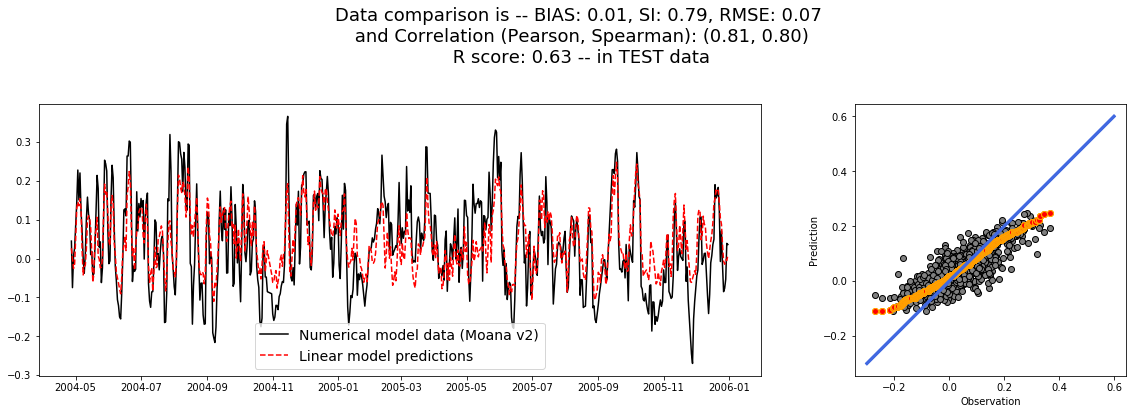

Data comparison is -- BIAS: 0.01, SI: 0.79, RMSE: 0.07
 and Correlation (Pearson, Spearman): (0.81, 0.80)
 R score: 0.63 -- in TEST data


In [11]:
# knn regression in kapiti island
ss_kapiti = load_geocean_tgs().sel(name='Kapiti_Is').resample(time='1D').max()
stats_stat, kapiti_model, train_times = KNN_Regression(
    pcs_cfsr, ss_kapiti, plot_results=True, verbose=True,
    max_neighbors=50, train_size=0.8
)


 loading and plotting the GeoOcean tidal guages... 


 71 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 50-max neighbors... 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    2.2s finished



 best model fitted with 17 neighbors!! 



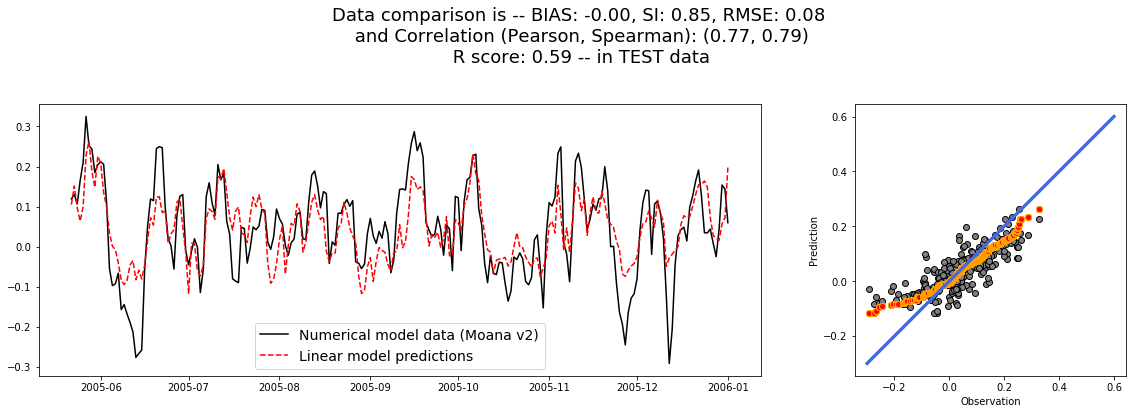

Data comparison is -- BIAS: -0.00, SI: 0.85, RMSE: 0.08
 and Correlation (Pearson, Spearman): (0.77, 0.79)
 R score: 0.59 -- in TEST data


In [12]:
# knn regression in green island
ss_green = load_geocean_tgs().sel(name='Green_Is').resample(time='1D').max()
stats_stat, green_model, train_times = KNN_Regression(
    pcs_cfsr, ss_green, plot_results=True, verbose=True,
    max_neighbors=50, train_size=0.8
)


 loading and plotting the GeoOcean tidal guages... 


 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 10, 10) 


 calculated PCs matrix with shape: 
 (11353, 200) 


 plotting 2 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



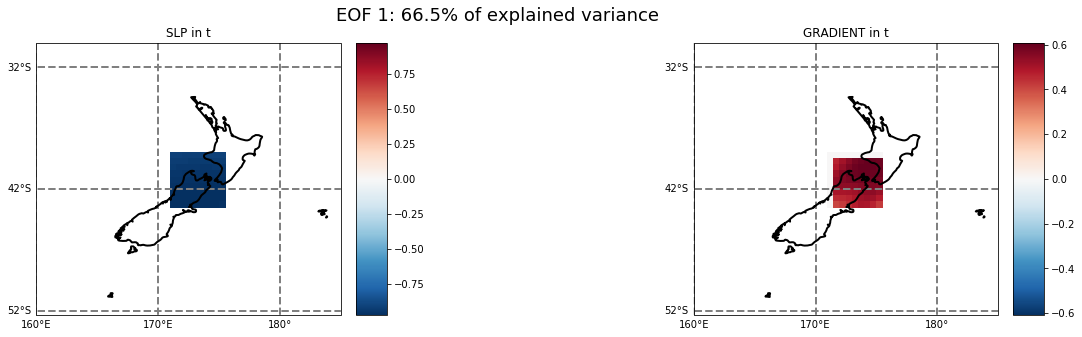

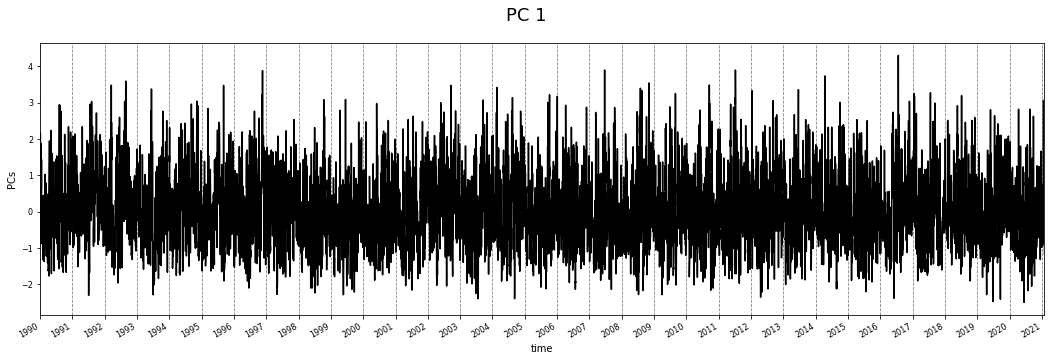

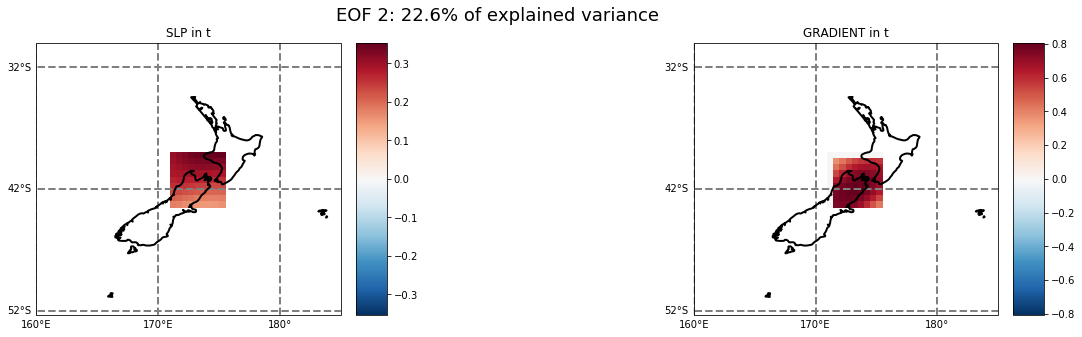

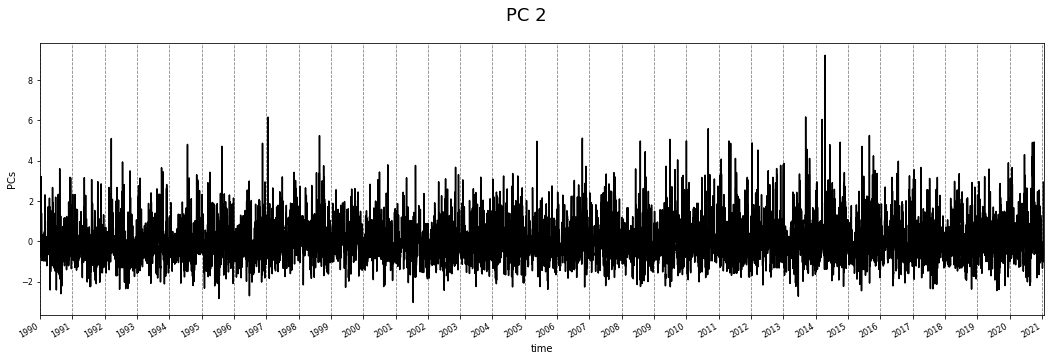


 2 PCs (0.9 expl. variance) will be used to train the model!! 


 KNN regression with 4 neighbors... 



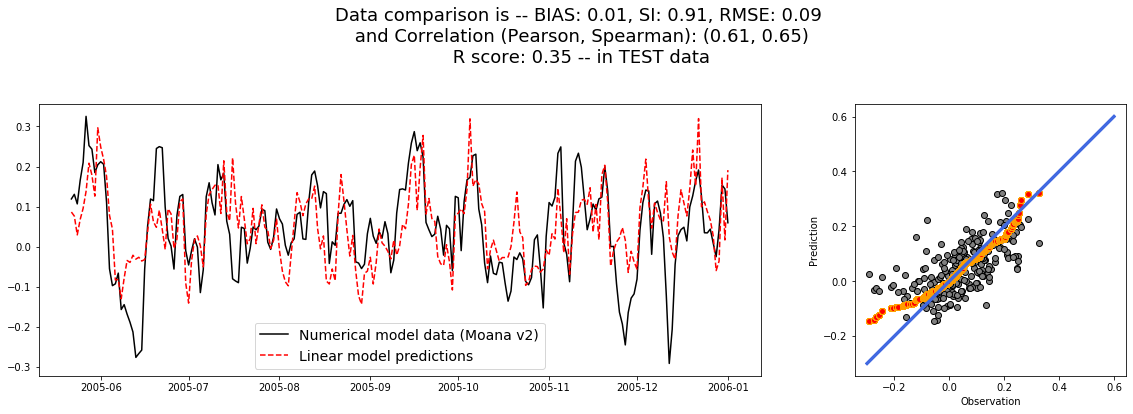

Data comparison is -- BIAS: 0.01, SI: 0.91, RMSE: 0.09
 and Correlation (Pearson, Spearman): (0.61, 0.65)
 R score: 0.35 -- in TEST data


In [13]:
# knn regression in green island
ss_green = load_geocean_tgs().sel(name='Green_Is').resample(time='1D').max()
stats_stat, green_model, train_times = KNN_Regression(
    PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp, 
        calculate_gradient=True, time_lapse=1,
        region=(True, (
            ss_moana.lon.values[0]-2.6,
            ss_moana.lon.values[0]+2.6,
            ss_moana.lat.values[0]+2.6,
            ss_moana.lat.values[0]-2.6
        )),
        pca_plot=(True,False), verbose=True
    )[0], 
    ss_green, plot_results=True, verbose=True,
    k_neighbors=4, train_size=0.8
)

## knn regression with local predictor

In [14]:
run = False
if run:
    # perform the KNN-Regression (local)
    stats_local = []
    sites_local = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),12
    )
    for stat in progressbar.progressbar(sites_local):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat, model, train_times = KNN_Regression(
            PCA_DynamicPred(
                load_cfsr_moana_uhslc.predictor_slp, 
                calculate_gradient=True, time_lapse=1,
                region=(True, (
                    ss_moana.lon.values[0]-2.6,
                    ss_moana.lon.values[0]+2.6,
                    ss_moana.lat.values[0]+2.6,
                    ss_moana.lat.values[0]-2.6
                )),
                pca_plot=(False,False), verbose=False
            )[0],
            ss_moana # search with grid-search-cv
        )
        stats_local.append(stats_stat)
    # save the statistics
    stats_local = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_local)[:,0]),
            'si':(('station'),np.array(stats_local)[:,1]),
            'rmse':(('station'),np.array(stats_local)[:,2]),
            'pearson':(('station'),np.array(stats_local)[:,3]),
            'spearman':(('station'),np.array(stats_local)[:,4]),
            'rscore':(('station'),np.array(stats_local)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lon)
        },
        coords={
            'station': sites_local
        }
    )
    # local copy
    if True:
        stats_local.to_netcdf(data_path+'/statistics/stats_knn_local_daily.nc')
else:
    stats_local = xr.open_dataset(
        data_path+'/statistics/stats_knn_local_daily.nc'
    )

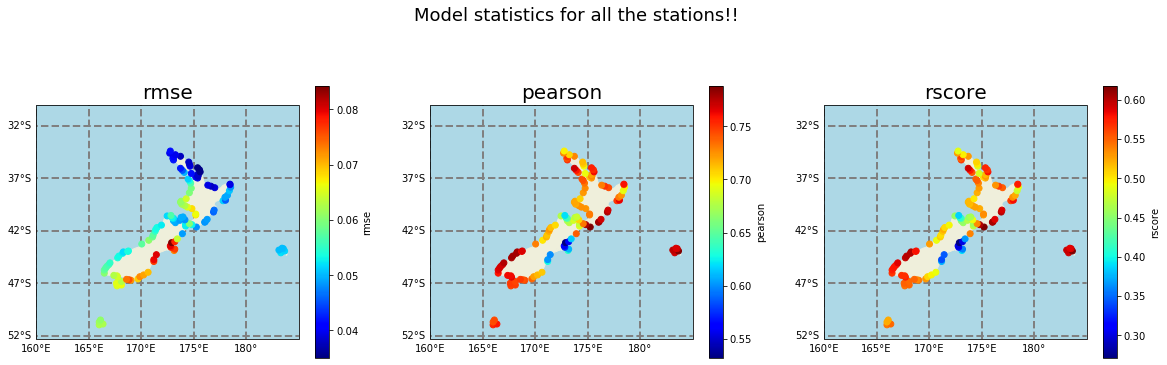

In [15]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_local,plot_stats=['rmse','pearson','rscore'])